In [1]:
using Statistics
using Distributed
using PyPlot

In [8]:
"""
Start Julia run with the following command:
    julia -p auto

.int file format specification:
    * Each image is encoded by 1+28^2 bytes.
    * Images are stored consecutively.
    * First byte for each image is its class from 0 to 9
    * Then each of remaining 28^2 has value from 0 to 255
      and encodes one entry in a 28x28 image
"""

@everywhere const TRAIN = (class=UInt8[], image=Matrix{Int32}[])
@everywhere const TEST = (class=UInt8[], image=Matrix{Int32}[])

@everywhere for (filename, data) in [("mnist/mnist_train.int", TRAIN),
                                     ("mnist/mnist_test.int", TEST)]
    open(filename) do f
        while !eof(f)
            c = read(f, UInt8)
            v = read(f, 28^2)
            push!(data.class, c)
            push!(data.image, reshape(v, 28, 28))
        end
    end
end

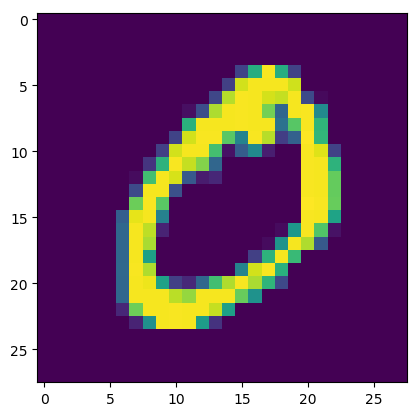

PyObject <matplotlib.image.AxesImage object at 0x7f0e206b1e10>

In [3]:
imshow(TRAIN.image[1])

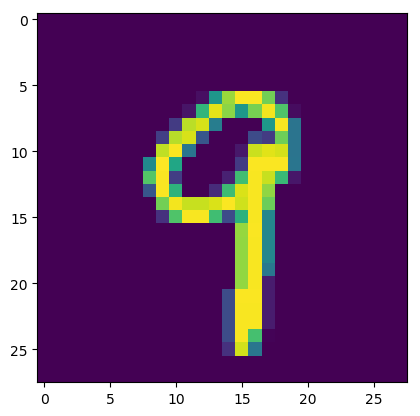

PyObject <matplotlib.image.AxesImage object at 0x7f0e185109e8>

In [4]:
imshow(TRAIN.image[end])

In [6]:
addprocs(3)
nworkers()

3

In [12]:
?Ref

search: Ref WeakRef prevfloat UndefRefError GlobalRef plot_wireframe rcdefaults



```
Ref{T}
```

An object that safely references data of type `T`. This type is guaranteed to point to valid, Julia-allocated memory of the correct type. The underlying data is protected from freeing by the garbage collector as long as the `Ref` itself is referenced.

In Julia, `Ref` objects are dereferenced (loaded or stored) with `[]`.

Creation of a `Ref` to a value `x` of type `T` is usually written `Ref(x)`. Additionally, for creating interior pointers to containers (such as Array or Ptr), it can be written `Ref(a, i)` for creating a reference to the `i`-th element of `a`.

When passed as a `ccall` argument (either as a `Ptr` or `Ref` type), a `Ref` object will be converted to a native pointer to the data it references.

There is no invalid (NULL) `Ref` in Julia, but a `C_NULL` instance of `Ptr` can be passed to a `ccall` Ref argument.


In [ ]:
@everywhere function distance(a, b)
    d = 0
    @simd for i in 1:length(a)
        @inbounds d += (a[i] - b[i]) ^ 2
    end
    d
end

@everywhere function knnacc(i)
    dist = distance.(Ref(TEST.image[i]), TRAIN.image)
    knn_loc = partialsortperm(dist, 1:20)
    TRAIN.class[knn_loc]
end

@time neivec = pmap(knnacc, axes(TEST.class, 1))
const NEIGHBOURS = reduce(hcat, neivec)

function acc(classes, testclass)
    v = zeros(Int, 10)
    for c in classes
        v[c + 1] += 1
    end
    m = maximum(v)
    (v[testclass + 1] == m) / count(==(m), v)
end

function evalk(k)
    mean(axes(NEIGHBOURS, 2)) do i
        classes = view(NEIGHBOURS, 1:k, i)
        testclass = TEST.class[i]
        acc(classes, testclass)
    end
end

plot(evalk.(axes(NEIGHBOURS, 1)))


In [13]:
?axes

search: axes Axes3D delaxes axvline axhline CapturedException



```
axes(A, d)
```

Return the valid range of indices for array `A` along dimension `d`.

See also [`size`](@ref), and the manual chapter on [arrays with custom indices](@ref man-custom-indices).

# Examples

```jldoctest
julia> A = fill(1, (5,6,7));

julia> axes(A, 2)
Base.OneTo(6)
```

---

```
axes(A)
```

Return the tuple of valid indices for array `A`.

# Examples

```jldoctest
julia> A = fill(1, (5,6,7));

julia> axes(A)
(Base.OneTo(5), Base.OneTo(6), Base.OneTo(7))
```
